## Business Understanding

In this ever-changing landscape of real estate market, it is very difficult to navigate without a proper set of services and tools. As  a technology company that serves agents/brokers across various California bay Area counties and provides them with listing information, services and training to succeed. But how do we target these trainings, tools and services to the set of subscribers who need them the most? To understand that, we can try to classify our subscribers into performance buckets for example Top Agents vs Not. Then study the traits of the high performing subscribers and identify the missing traits from the Negative group and extend our services.  As first step, I would like to work towards answering the questions given below to further reach the business objective.

What are the different characteristics that make a Real Estate Agent successful? 

Can we predict how successful a real estate agent is going to be given a set of features?



### Data Understanding

In order to answer the business questions, I am using the data of around 18,000 real estate agents with 20 features for the last 4 quarters.

#### Understanding the Features

```
Input variables

TotalSales - (Numeric)Number of transactions in the last year  
saleVolume -  (Numeric) Total volumes of Sale for all transactions
License    - Real Estate License Number    
county     - County
AgentRole  - Broker,Agent
BrokerCode - Broker 
Biography  - y/n If biography entered in the public profile
Languages  - (Numeric)Number of spoken languages
Specialties - Other real Estate specializations
ZipCodesServed  - Number of zip codes served by the subscriber
SocialPlatform  - y/n If socially active in FB,twitter, instagram etc
AllowLeadsYN    -  
PhoneDisplayPublicYN  - y/n If contact number is public
productionpublicyn    -y/n
profilepublicyn      y/n If profile is published on xonsumer sites
FeePaid              y/n If delinquent on MLS fee
Experience           (Numeric) Number of years member of MLS
PlanType              Subscription Plantype
NumberofContacts      Number of contacts (leads) in Matrix
Photo                y/n If Profile includes photo

Target Variable (Desired output)

TopAgent   - Target Field Y - Classified as the top 20% list of Agents   
```

In [186]:
#Import the necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score,  ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import recall_score,f1_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import VotingClassifier
from sklearn import set_config
set_config(display="diagram")
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings('ignore')

## Exploratory Data Analysis (EDA)

In [94]:
# Let's first read the sub datasets 1 - Top Agent Data, 2 Member Features and merge them for each subscriber
dftopagent = pd.read_excel('data/topagentv2.xlsx')
dfmember=pd.read_excel('data/memberv2.xlsx').dropna()
newdf = dftopagent.merge(dfmember, how='left')

In [95]:
# Scan the resultant dataset to check the datatypes 
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25554 entries, 0 to 25553
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TotalSales            25554 non-null  int64  
 1   saleVolume            25554 non-null  int64  
 2   License               25554 non-null  object 
 3   TopAgent              25554 non-null  object 
 4   county                25554 non-null  object 
 5   AgentRole             20260 non-null  float64
 6   BrokerCode            20260 non-null  object 
 7   Biography             20260 non-null  float64
 8   Languages             20260 non-null  float64
 9   Specialties           20260 non-null  float64
 10  ZipCodesServed        20260 non-null  float64
 11  SocialPlatform        20260 non-null  float64
 12  AllowLeadsYN          20260 non-null  float64
 13  PhoneDisplayPublicYN  20260 non-null  float64
 14  productionpublicyn    20260 non-null  float64
 15  profilepublicyn    

Text(0, 0.5, 'null count')

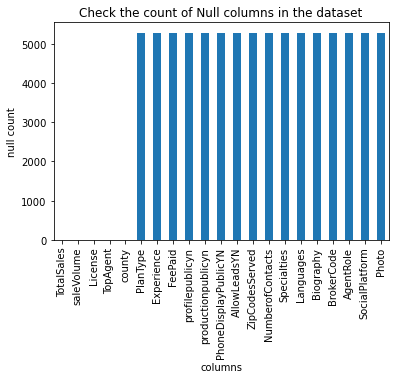

In [96]:
# Plot the null data for all the features
nullplot=newdf.isnull().sum().sort_values().plot(kind = 'bar',title="Check the count of Null columns in the dataset")
nullplot.set_xlabel("columns")
nullplot.set_ylabel("null count")

### Data Findings

Around 5000 records have null values for majority columns so decided to drop them.

Since the TotalSales and saleVolume are highly correlated to the target field Top Agent, the results can be biased so dropping these columns.

BrokerCode has wide range of values and not useful during encoding, so dropping.

Most agents have not uploaded their photo in the app so this column does not add value.

License Number is the primary field and adds no value to the target so, we need to drop it.


### Data Preparation

In [97]:
newdf = newdf.drop(['AgentRole','TotalSales','saleVolume','Photo','BrokerCode','License','FeePaid'], axis=1).dropna()

In [98]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20260 entries, 0 to 25553
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TopAgent              20260 non-null  object 
 1   county                20260 non-null  object 
 2   Biography             20260 non-null  float64
 3   Languages             20260 non-null  float64
 4   Specialties           20260 non-null  float64
 5   ZipCodesServed        20260 non-null  float64
 6   SocialPlatform        20260 non-null  float64
 7   AllowLeadsYN          20260 non-null  float64
 8   PhoneDisplayPublicYN  20260 non-null  float64
 9   productionpublicyn    20260 non-null  float64
 10  profilepublicyn       20260 non-null  float64
 11  Experience            20260 non-null  float64
 12  PlanType              20260 non-null  object 
 13  NumberofContacts      20260 non-null  float64
dtypes: float64(11), object(3)
memory usage: 2.3+ MB


In [99]:
newdf

,TopAgent,county,Biography,Languages,Specialties,ZipCodesServed,SocialPlatform,AllowLeadsYN,PhoneDisplayPublicYN,productionpublicyn,profilepublicyn,Experience,PlanType,NumberofContacts
0,Yes,Santa Clara,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,23.0,Annual,39.0
1,No,Santa Clara,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,29.0,Annual,31.0
3,No,Santa Clara,1.0,1.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,Quarterly,16.0
4,No,San Mateo,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,3.0,Annual,1.0
5,No,Santa Cruz,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,17.0,Annual,346.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25548,No,Santa Cruz,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,7.0,Annual,8.0
25550,No,Santa Clara,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,5.0,Annual,144.0
25551,No,San Mateo,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,26.0,Annual,4.0
25552,No,San Mateo,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,26.0,Annual,4.0


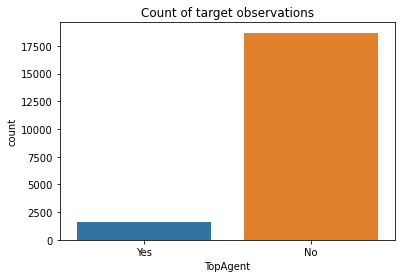

In [100]:
sns.countplot(data=newdf, x = 'TopAgent')
plt.title('Count of target observations');

In [101]:
newdf.corr()

,Biography,Languages,Specialties,ZipCodesServed,SocialPlatform,AllowLeadsYN,PhoneDisplayPublicYN,productionpublicyn,profilepublicyn,Experience,NumberofContacts
Biography,1.000000,0.145824,0.428726,0.429899,0.378412,-0.004622,0.000263,-0.008466,0.008915,0.000679,0.064158
Languages,0.145824,1.000000,0.449688,0.298944,0.171931,0.006766,0.008308,-0.001104,0.003092,-0.133238,0.031443
Specialties,0.428726,0.449688,1.000000,0.706090,0.410058,0.018712,0.022400,0.009089,0.025115,-0.033556,0.092747
ZipCodesServed,0.429899,0.298944,0.706090,1.000000,0.396012,0.037296,0.032019,0.022948,0.038105,-0.002000,0.090483
SocialPlatform,0.378412,0.171931,0.410058,0.396012,1.000000,-0.006032,0.004368,-0.008929,0.011297,-0.020800,0.119564
AllowLeadsYN,-0.004622,0.006766,0.018712,0.037296,-0.006032,1.000000,0.895088,0.819157,0.927500,0.098048,0.030338
PhoneDisplayPublicYN,0.000263,0.008308,0.022400,0.032019,0.004368,0.895088,1.000000,0.800215,0.927500,0.103487,0.030414
productionpublicyn,-0.008466,-0.001104,0.009089,0.022948,-0.008929,0.819157,0.800215,1.000000,0.835895,0.099737,0.030643
profilepublicyn,0.008915,0.003092,0.025115,0.038105,0.011297,0.927500,0.927500,0.835895,1.000000,0.097480,0.027122
Experience,0.000679,-0.133238,-0.033556,-0.002000,-0.020800,0.098048,0.103487,0.099737,0.097480,1.000000,0.135103


<AxesSubplot:>

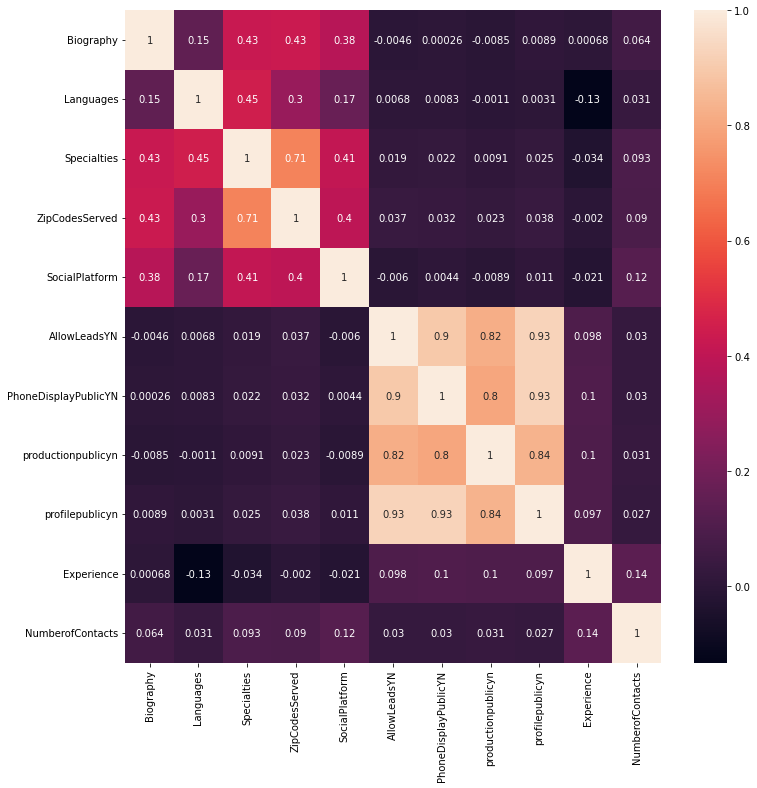

In [102]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(newdf.corr(), annot=True) 

Text(0.5, 1.0, 'Count plot Agents across counties ')

<Figure size 1440x720 with 0 Axes>

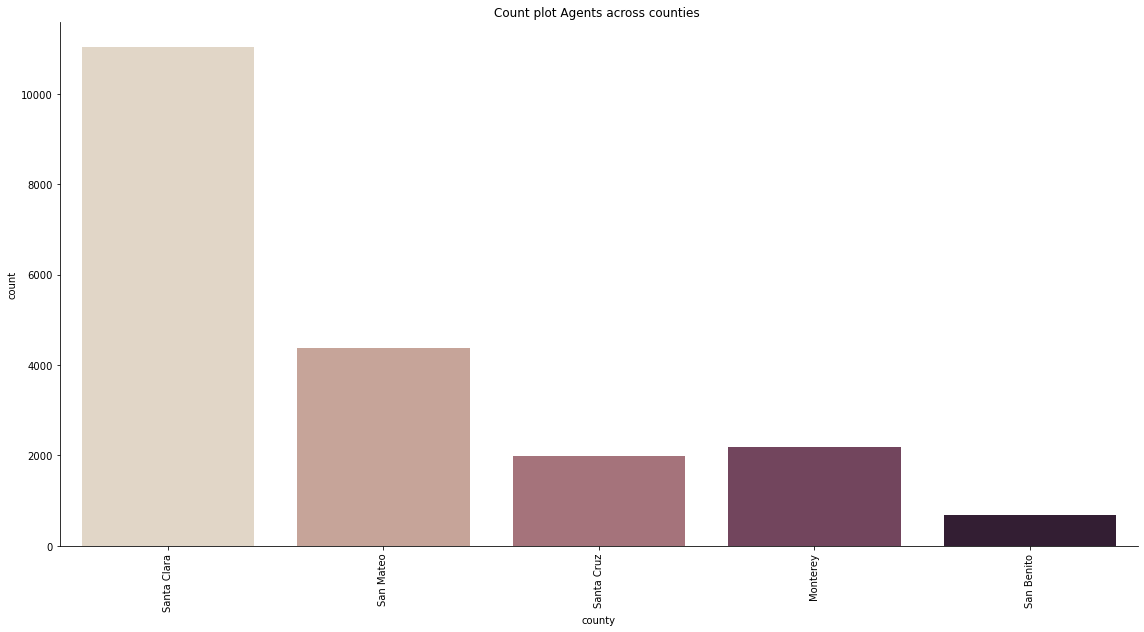

In [103]:
plt.figure(figsize=(20, 10))
sns.catplot(x="county", kind="count", palette="ch:.25", height=8, aspect=2, data=newdf);
plt.xticks(rotation=90);
plt.title('Count plot Agents across counties ')

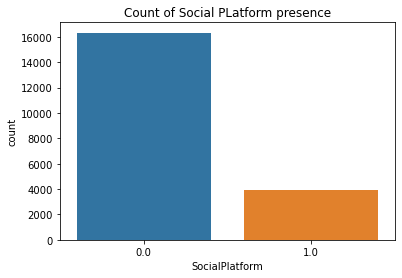

In [104]:
sns.countplot(data=newdf, x = 'SocialPlatform')
plt.title('Count of Social PLatform presence');

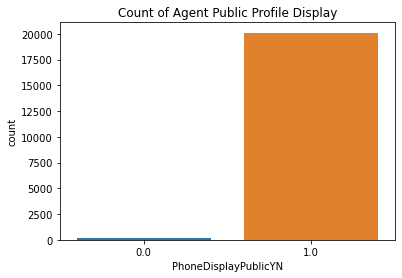

In [106]:
sns.countplot(data=newdf, x = 'PhoneDisplayPublicYN')
plt.title('Count of Agent Public Profile Display');

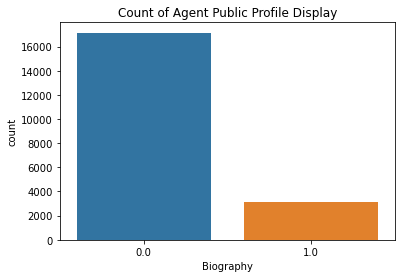

In [158]:
sns.countplot(data=newdf, x = 'Biography')
plt.title('Count of Agent Public Profile Display');

Skewness: -0.747223


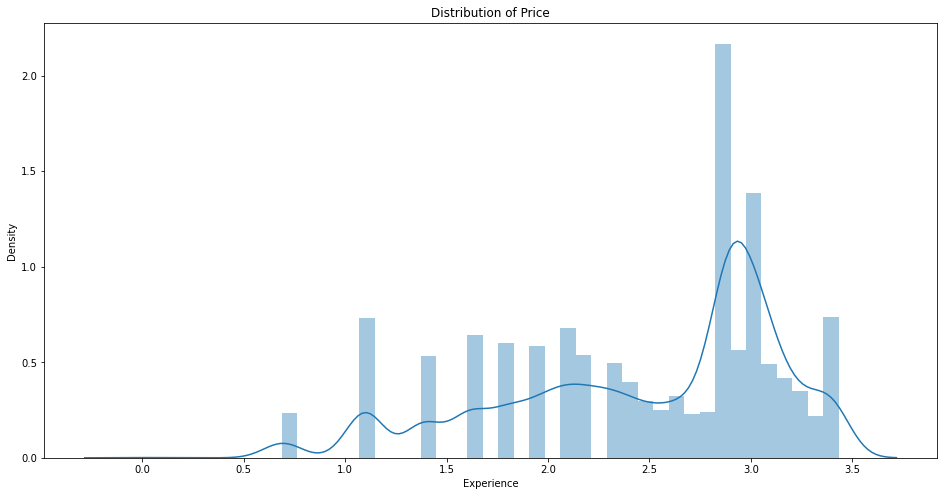

In [108]:
plt.figure(figsize=(16,8))
sns.distplot(np.log1p(newdf["Experience"]))
plt.title('Distribution of Price')
print("Skewness: %f" % np.log1p(newdf["Experience"]).skew())

Text(0.5, 1.0, 'Count plot Agents across ')

<Figure size 1440x720 with 0 Axes>

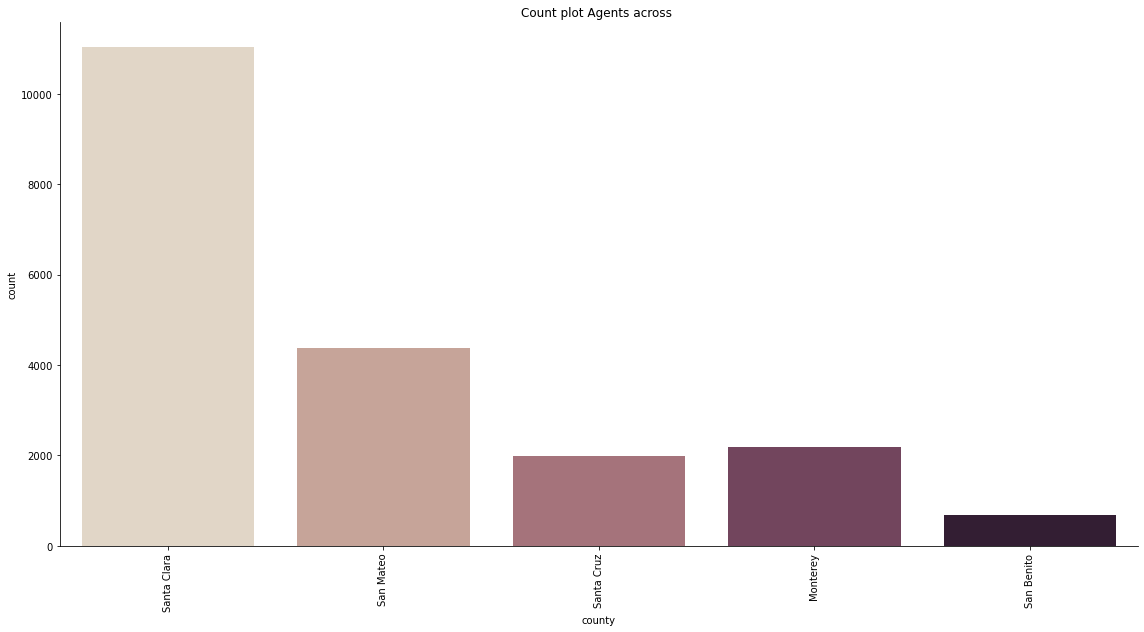

In [109]:
plt.figure(figsize=(20, 10))
sns.catplot(x="county", kind="count", palette="ch:.25", height=8, aspect=2, data=newdf);
plt.xticks(rotation=90);
plt.title('Count plot Agents across ')

In [110]:
newdf['Experience']=np.log1p(newdf["Experience"])

### EDA Finding

Looking at the target field, suggests extremely imbalanced classification. We may need to use class weight suring modeling.

The heatmap suggests some coorelated variables.

Most features ar binary in nature and assumes a value of either 1 or 0.

There are 3 categorical fields Plantype, County,and FeePaid,and requires encoding suring modeling

Since most features have binary values, the outliers need not be interpreted

The distribution of Experience need to be normailized by using log.

## Modeling

In [111]:
X = newdf.drop('TopAgent', axis = 1)
y = newdf['TopAgent']

In [112]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20260 entries, 0 to 25553
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   TopAgent              20260 non-null  object 
 1   county                20260 non-null  object 
 2   Biography             20260 non-null  float64
 3   Languages             20260 non-null  float64
 4   Specialties           20260 non-null  float64
 5   ZipCodesServed        20260 non-null  float64
 6   SocialPlatform        20260 non-null  float64
 7   AllowLeadsYN          20260 non-null  float64
 8   PhoneDisplayPublicYN  20260 non-null  float64
 9   productionpublicyn    20260 non-null  float64
 10  profilepublicyn       20260 non-null  float64
 11  Experience            20260 non-null  float64
 12  PlanType              20260 non-null  object 
 13  NumberofContacts      20260 non-null  float64
dtypes: float64(11), object(3)
memory usage: 2.3+ MB


In [113]:
# newdf.Languages.unique()
# newdf.Specialties.unique()
newdf.ZipCodesServed.unique()

array([1., 2.])

### Modeling Steps

Using One hot encoding for categorical fields.

All numerical fields can be run using Standard Scalar

The final dataset is split into train and test using 70 30 split

Create basic model with default values using Logistic Regression, KNN, Decision Trees, and SVM

In [115]:
# num_cols = ['TotalSales','saleVolume'] 

num_cols = ['Experience','Languages','Specialties','ZipCodesServed','Biography','SocialPlatform','AllowLeadsYN','PhoneDisplayPublicYN','productionpublicyn','profilepublicyn'] 
# ordinal_cols =  ['Languages','Specialties','ZipCodesServed'] 
ohe_cols = ['county','PlanType']

In [116]:
ordinal_ohe_transformer = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ohe_cols),
# (OrdinalEncoder(), ordinal_cols),
                                             
                                          remainder=StandardScaler())

In [117]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=22)

In [118]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14182 entries, 13533 to 14062
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county                14182 non-null  object 
 1   Biography             14182 non-null  float64
 2   Languages             14182 non-null  float64
 3   Specialties           14182 non-null  float64
 4   ZipCodesServed        14182 non-null  float64
 5   SocialPlatform        14182 non-null  float64
 6   AllowLeadsYN          14182 non-null  float64
 7   PhoneDisplayPublicYN  14182 non-null  float64
 8   productionpublicyn    14182 non-null  float64
 9   profilepublicyn       14182 non-null  float64
 10  Experience            14182 non-null  float64
 11  PlanType              14182 non-null  object 
 12  NumberofContacts      14182 non-null  float64
dtypes: float64(11), object(2)
memory usage: 1.5+ MB


### Logistic Regression

In [119]:
%%time
lr_model = Pipeline([('transformer', ordinal_ohe_transformer),
     ('logreg', LogisticRegression(max_iter=10000))])
lr_model.fit(X_train, y_train)
y_predict_train = lr_model.predict(X_train)
y_predict_test = lr_model.predict(X_test)

CPU times: total: 188 ms
Wall time: 182 ms


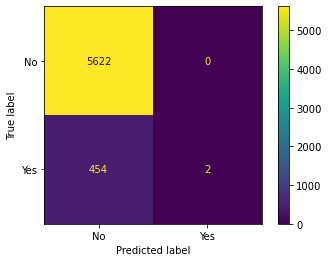

In [120]:
confusion_mat  = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat,display_labels = ['No', 'Yes'])
disp.plot()
plt.grid(False)
plt.show()

In [121]:
lr_train = accuracy_score(y_train, y_predict_train)
lr_test = accuracy_score(y_test, y_predict_test)

print(f'Train Accuracy: {lr_train}')
print(f'Test Accuracy: {lr_test} ')

Train Accuracy: 0.921802284586095
Test Accuracy: 0.9253043764396183 


### KNN

In [122]:
%%time
knn_model = Pipeline([('transformer', ordinal_ohe_transformer),
     ('logreg', KNeighborsClassifier())])
knn_model.fit(X_train, y_train)
y_predict_train = knn_model.predict(X_train)
y_predict_test = knn_model.predict(X_test)

CPU times: total: 13.5 s
Wall time: 6.46 s


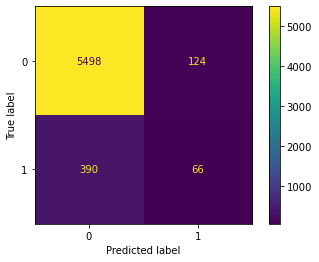

In [123]:
confusion_mat  = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
disp.plot()
plt.grid(False)
plt.show()

In [124]:
knn_train = accuracy_score(y_train, y_predict_train)
knn_test = accuracy_score(y_test, y_predict_test)

print(f'Train Accuracy: {knn_train}')
print(f'Test Accuracy: {knn_test} ')

Train Accuracy: 0.932802143562262
Test Accuracy: 0.9154327081276735 


### Decision Tree

In [125]:
%%time
dt_model = Pipeline([('transformer', ordinal_ohe_transformer),
     ('dt', DecisionTreeClassifier())])
dt_model.fit(X_train, y_train)
y_predict_train = dt_model.predict(X_train)
y_predict_test = dt_model.predict(X_test)

CPU times: total: 141 ms
Wall time: 128 ms


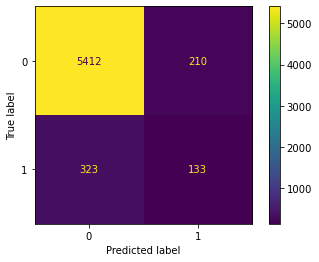

In [126]:
confusion_mat  = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
disp.plot()
plt.grid(False)
plt.show()

In [127]:
dt_train = accuracy_score(y_train, y_predict_train)
dt_test = accuracy_score(y_test, y_predict_test)

print(f'Train Accuracy: {dt_train}')
print(f'Test Accuracy: {dt_test} ')

Train Accuracy: 0.9507121703567903
Test Accuracy: 0.9123066798288911 


### SVM

In [128]:
%%time
svm_model = Pipeline([('transformer', ordinal_ohe_transformer),
     ('dt', SVC( kernel= 'rbf',class_weight='balanced', probability=True))])
svm_model.fit(X_train, y_train)
y_predict_train = svm_model.predict(X_train)
y_predict_test = svm_model.predict(X_test)

CPU times: total: 8min 42s
Wall time: 8min 44s


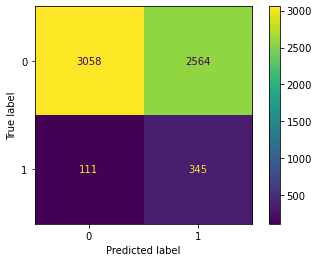

In [50]:
confusion_mat  = confusion_matrix(y_test, y_predict_test)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat)
disp.plot()
plt.grid(False)
plt.show()

In [129]:
svm_train = accuracy_score(y_train, y_predict_train)
svm_test = accuracy_score(y_test, y_predict_test)

print(f'Train Accuracy: {svm_train}')
print(f'Test Accuracy: {svm_test} ')

Train Accuracy: 0.5700183330982936
Test Accuracy: 0.5613688713392563 


In [130]:
res_dict = {'model': ['Logistic Regression','KNN', 'Decision Tree', 'SVC'],
           'train accuracy': [92, 93, 95, 57],
           'test accuracy': [92, 91, 91, 56],
           'train time/seconds': [.2, 14, 1, 524]}
results_df = pd.DataFrame(res_dict).set_index('model')
results_df

,train accuracy,test accuracy,train time/seconds
model,,,
Logistic Regression,92,92,0.2
KNN,93,91,14.0
Decision Tree,95,91,1.0
SVC,57,56,524.0


### Initial Findings

The Decision Tree performed the best in terms of accuracy.

KNN and Logistics were te next best but looking at the training time Logistic Regression performed better.

Let's try hyperparameter tuning for different classifiers

## Model Improvement using Gridsearch with hyperparameter tuning

After running different model using default values, we can improve the model performance by tuning the parameters that are sensitive to each model by using Gridseacrch by supplying a range of values for each model.

### Decision Tree with Hyperparameter tuning

In [131]:
dt_params = {'dt__max_depth': range(1,7),
         'dt__min_samples_split': [.1,.2,.3,.05],
          'dt__criterion': ['gini','entropy'],
          'dt__min_samples_leaf': [1,2,3,4,5]
         }

dt_pipe = Pipeline([
    ('transformer', ordinal_ohe_transformer),
#     ('scaler', StandardScaler()),
    ('dt', DecisionTreeClassifier(random_state = 42))
])

dt_grid = GridSearchCV(dt_pipe, param_grid=dt_params, scoring='roc_auc',cv=5)
print(dt_pipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'dt', 'transformer__n_jobs', 'transformer__remainder__copy', 'transformer__remainder__with_mean', 'transformer__remainder__with_std', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__onehotencoder', 'transformer__onehotencoder__categories', 'transformer__onehotencoder__drop', 'transformer__onehotencoder__dtype', 'transformer__onehotencoder__handle_unknown', 'transformer__onehotencoder__sparse', 'dt__ccp_alpha', 'dt__class_weight', 'dt__criterion', 'dt__max_depth', 'dt__max_features', 'dt__max_leaf_nodes', 'dt__min_impurity_decrease', 'dt__min_samples_leaf', 'dt__min_samples_split', 'dt__min_weight_fraction_leaf', 'dt__random_state', 'dt__splitter'])


In [132]:
%%time
dt_grid.fit(X_train, y_train)

CPU times: total: 45.1 s
Wall time: 45.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['county',
                                                                          'PlanType'])])),
                                       ('dt',
                                        DecisionTreeClassifier(random_state=42))]),
             param_grid={'dt__criterion': ['gini', 'entropy'],
                         'dt__max_depth': range(1, 7),
                         'dt__min_samples_leaf': [1, 2, 3, 4, 5],
                         'dt__min_samples_split': [0.1, 0.2, 0.3, 0.05]},
             scoring='roc_auc')

In [133]:
print(dt_grid.best_params_)

{'dt__criterion': 'entropy', 'dt__max_depth': 6, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 0.2}


In [134]:
y_predict_train = dt_grid.predict(X_train)
y_predict_test = dt_grid.predict(X_test)
y_hat_probs = dt_grid.predict_proba(X_test)
print('ROCAUC score:',roc_auc_score(y_test, y_hat_probs[:, 1]))
print('Train Accuracy score:', accuracy_score(y_train, y_predict_train))
print('Test Accuracy score:', accuracy_score(y_test, y_predict_test))
# print('F1 score:',f1_score(y_test, y_predict_test))
print(classification_report(y_test, y_predict_test, target_names=['No', 'Yes']))

ROCAUC score: 0.669021918902557
Train Accuracy score: 0.9216612607530673
Test Accuracy score: 0.9249753208292202
              precision    recall  f1-score   support

          No       0.92      1.00      0.96      5622
         Yes       0.00      0.00      0.00       456

    accuracy                           0.92      6078
   macro avg       0.46      0.50      0.48      6078
weighted avg       0.86      0.92      0.89      6078



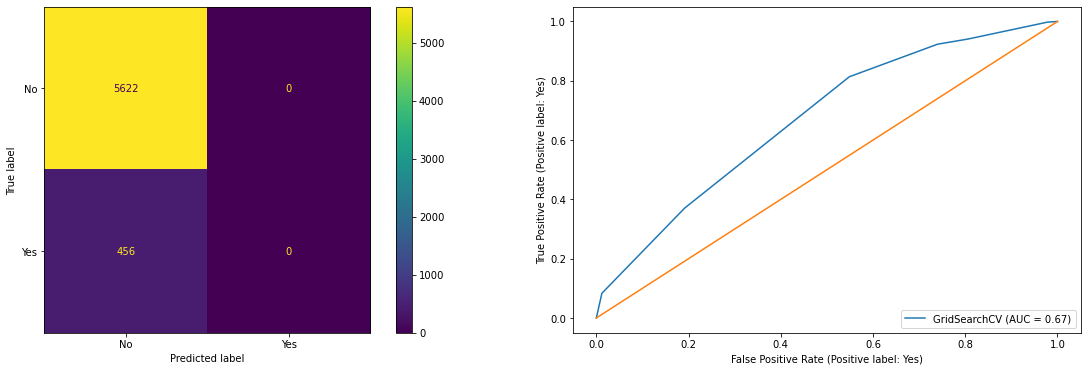

In [136]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(dt_grid, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(dt_grid, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### Logistic Regression with Hyper parameter tuning

In [137]:
lgr_params = {'lgr__penalty': ['l1', 'l2'],'lgr__C': np.logspace(-3,3,7),'lgr__solver'  : ['liblinear']},

lgr_pipe = Pipeline([
    ('transformer', ordinal_ohe_transformer),
#     ('scaler', StandardScaler()),
    ('lgr', LogisticRegression(class_weight='balanced',max_iter=10000))
])

lgr_grid = GridSearchCV(lgr_pipe, param_grid=lgr_params, scoring='roc_auc',cv=5)
print(lgr_pipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'lgr', 'transformer__n_jobs', 'transformer__remainder__copy', 'transformer__remainder__with_mean', 'transformer__remainder__with_std', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__onehotencoder', 'transformer__onehotencoder__categories', 'transformer__onehotencoder__drop', 'transformer__onehotencoder__dtype', 'transformer__onehotencoder__handle_unknown', 'transformer__onehotencoder__sparse', 'lgr__C', 'lgr__class_weight', 'lgr__dual', 'lgr__fit_intercept', 'lgr__intercept_scaling', 'lgr__l1_ratio', 'lgr__max_iter', 'lgr__multi_class', 'lgr__n_jobs', 'lgr__penalty', 'lgr__random_state', 'lgr__solver', 'lgr__tol', 'lgr__verbose', 'lgr__warm_start'])


In [138]:
%%time
lgr_grid.fit(X_train, y_train)

CPU times: total: 21.7 s
Wall time: 21.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['county',
                                                                          'PlanType'])])),
                                       ('lgr',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=10000))]),
             param_grid=({'lgr__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'lgr__penalty': ['l1', 'l2'],
                          'lgr__solver': ['liblinear']},),
             scoring='roc_auc')

In [139]:
print(lgr_grid.best_params_)

{'lgr__C': 0.1, 'lgr__penalty': 'l1', 'lgr__solver': 'liblinear'}


In [176]:
y_predict_train = lgr_grid.predict(X_train)
y_predict_test = lgr_grid.predict(X_test)
y_hat_probs = lgr_grid.predict_proba(X_test)
print('ROCAUC score:',roc_auc_score(y_test, y_hat_probs[:, 1]))
print('Train Accuracy score:', accuracy_score(y_train, y_predict_train))
print('Test Accuracy score:', accuracy_score(y_test, y_predict_test))
# print('F1 score:',f1_score(y_test, y_predict_test))
print(classification_report(y_test, y_predict_test, target_names=['No', 'Yes']))

ROCAUC score: 0.6755526924301147
Train Accuracy score: 0.5676209279368213
Test Accuracy score: 0.5635077328068444
              precision    recall  f1-score   support

          No       0.96      0.55      0.70      5622
         Yes       0.11      0.70      0.19       456

    accuracy                           0.56      6078
   macro avg       0.53      0.63      0.45      6078
weighted avg       0.89      0.56      0.66      6078



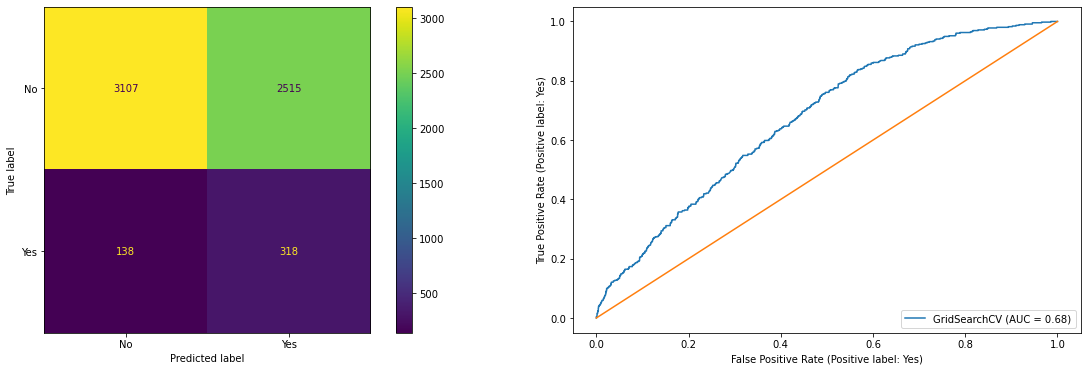

In [141]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(lgr_grid, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### KNN with Tuning using GridSearch

In [142]:
knn_params = {'knn__n_neighbors': range(1, 15, 1)},

knn_pipe = Pipeline([
    ('transformer', ordinal_ohe_transformer),
#     ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

knn_grid = GridSearchCV(knn_pipe, param_grid=knn_params, scoring='roc_auc',cv=5)
print(knn_pipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'knn', 'transformer__n_jobs', 'transformer__remainder__copy', 'transformer__remainder__with_mean', 'transformer__remainder__with_std', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__onehotencoder', 'transformer__onehotencoder__categories', 'transformer__onehotencoder__drop', 'transformer__onehotencoder__dtype', 'transformer__onehotencoder__handle_unknown', 'transformer__onehotencoder__sparse', 'knn__algorithm', 'knn__leaf_size', 'knn__metric', 'knn__metric_params', 'knn__n_jobs', 'knn__n_neighbors', 'knn__p', 'knn__weights'])


In [143]:
%%time
knn_grid.fit(X_train, y_train)

CPU times: total: 2min 39s
Wall time: 46.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder=StandardScaler(),
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['county',
                                                                          'PlanType'])])),
                                       ('knn', KNeighborsClassifier())]),
             param_grid=({'knn__n_neighbors': range(1, 15)},),
             scoring='roc_auc')

In [144]:
y_predict_train = knn_grid.predict(X_train)
y_predict_test = knn_grid.predict(X_test)
y_hat_probs = knn_grid.predict_proba(X_test)
print('ROCAUC score:',roc_auc_score(y_test, y_hat_probs[:, 1]))
print('Train Accuracy score:', accuracy_score(y_train, y_predict_train))
print('Test Accuracy score:', accuracy_score(y_test, y_predict_test))
# print('F1 score:',f1_score(y_test, y_predict_test))
print(classification_report(y_test, y_predict_test, target_names=['No', 'Yes']))

ROCAUC score: 0.7223948288989995
Train Accuracy score: 0.9246227612466507
Test Accuracy score: 0.9211911813096413
              precision    recall  f1-score   support

          No       0.93      0.99      0.96      5622
         Yes       0.35      0.06      0.10       456

    accuracy                           0.92      6078
   macro avg       0.64      0.53      0.53      6078
weighted avg       0.89      0.92      0.89      6078



In [159]:
print(knn_grid.best_params_)

{'knn__n_neighbors': 9}


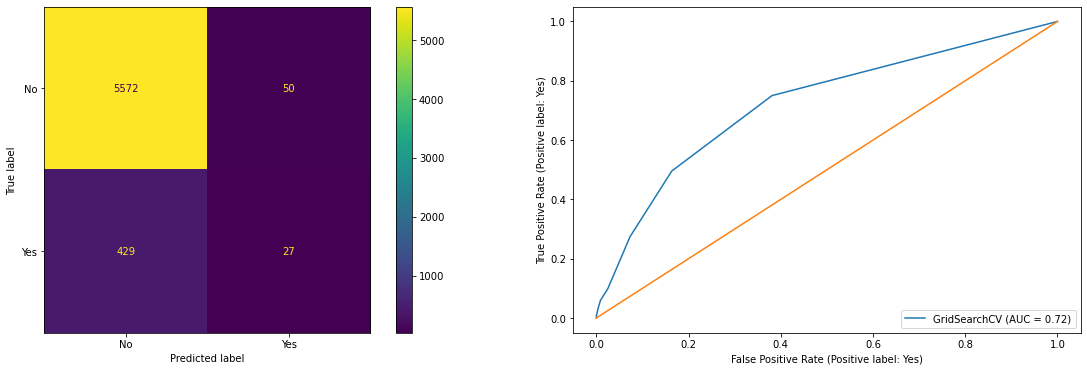

In [146]:
fig, ax = plt.subplots(1, 2, figsize = (20, 6))
ConfusionMatrixDisplay.from_estimator(knn_grid, X_test, y_test, ax = ax[0])
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, ax = ax[1])
ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### SVM with GridSearchCV

In [77]:

svc_params = {'svc__C': [0.1,1, 10, 100], 'svc__gamma': [1,0.1,0.01,0.001],'svc__kernel': ['rbf', 'poly', 'sigmoid']}
svc_pipe = Pipeline([
    ('transformer', ordinal_ohe_transformer),
#     ('scaler', StandardScaler()),
    ('svc', SVC(probability=True))
])

svc_grid = GridSearchCV(svc_pipe, param_grid=svc_params, scoring='roc_auc',cv=5)
print(svc_pipe.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'transformer', 'svc', 'transformer__n_jobs', 'transformer__remainder__copy', 'transformer__remainder__with_mean', 'transformer__remainder__with_std', 'transformer__remainder', 'transformer__sparse_threshold', 'transformer__transformer_weights', 'transformer__transformers', 'transformer__verbose', 'transformer__verbose_feature_names_out', 'transformer__onehotencoder', 'transformer__onehotencoder__categories', 'transformer__onehotencoder__drop', 'transformer__onehotencoder__dtype', 'transformer__onehotencoder__handle_unknown', 'transformer__onehotencoder__sparse', 'svc__C', 'svc__break_ties', 'svc__cache_size', 'svc__class_weight', 'svc__coef0', 'svc__decision_function_shape', 'svc__degree', 'svc__gamma', 'svc__kernel', 'svc__max_iter', 'svc__probability', 'svc__random_state', 'svc__shrinking', 'svc__tol', 'svc__verbose'])


In [78]:
# %%time
# svc_grid.fit(X_train, y_train)

In [79]:
# fig, ax = plt.subplots(1, 2, figsize = (20, 6))
# ConfusionMatrixDisplay.from_estimator(svc_grid, X_test, y_test, ax = ax[0])
# RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, ax = ax[1])
# ax[1].plot(np.array([0, 1]), np.array([0, 1]))

### Classifier comparison

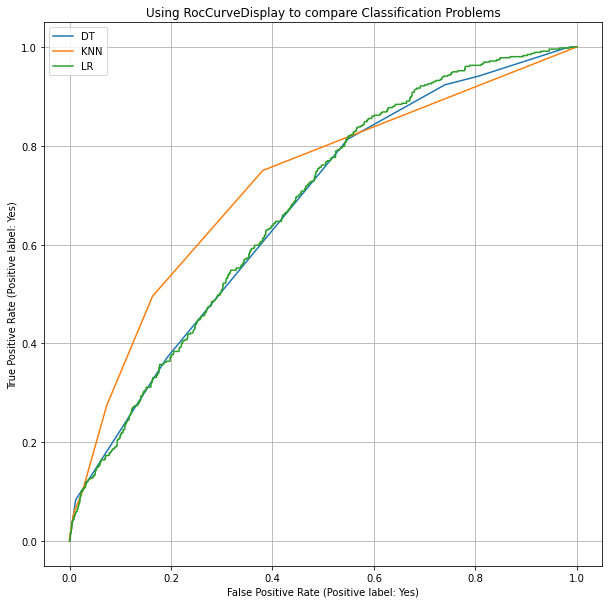

In [147]:
fig, ax = plt.subplots(figsize=(10, 10))
# RocCurveDisplay.from_estimator(svc_grid, X_test, y_test, ax = ax,label = 'SVC')
RocCurveDisplay.from_estimator(dt_grid, X_test, y_test, ax = ax,label = 'DT')
RocCurveDisplay.from_estimator(knn_grid, X_test, y_test, ax = ax,label = 'KNN')
RocCurveDisplay.from_estimator(lgr_grid, X_test, y_test, ax = ax,label = 'LR')
plt.grid()
plt.title('Using RocCurveDisplay to compare Classification Problems')
plt.legend();

## Tuned Model Findings

After tuning the various classifiers using gridsearch, KNN performed better with ROCAUC score of 72. The best params are {'knn__n_neighbors': 9} 

Logistic regression train and test accuracy were not optimal but with ROCAUC score of 68 it was the second best model. The best params were {'lgr__C': 0.1, 'lgr__penalty': 'l1', 'lgr__solver': 'liblinear'}

SVM took a really long time to run, hence I cancelled the fit.



In [178]:
lr_model_final = Pipeline([('transformerlr', ordinal_ohe_transformer),('classifier', LogisticRegression(C= .1, penalty= 'l1', solver= 'liblinear'))])
lr_model_final.fit(X_train, y_train)
y_predict_train = lr_model_final.predict(X_train)
y_predict_test = lr_model_final.predict(X_test)

In [179]:

knn_model_final = Pipeline([('transformerknn', ordinal_ohe_transformer),('classifier', KNeighborsClassifier(n_neighbors= 9))])
knn_model_final.fit(X_train, y_train)
y_predict_train = knn_model_final.predict(X_train)
y_predict_test = knn_model_final.predict(X_test)


In [180]:
knn_model_final.score(X_test,y_test)

0.9211911813096413

In [181]:
lr_model_final.score(X_test,y_test)

0.9249753208292202

### Model Improvement using Ensemble Technique

In [203]:
voter = VotingClassifier([ ('lgr', LogisticRegression(C= .1, penalty= 'l1', solver= 'liblinear')), ('knn', KNeighborsClassifier(n_neighbors= 9))
                      , ('dt', DecisionTreeClassifier(criterion='entropy',max_depth= 6, min_samples_leaf= 1, min_samples_split=0.2))   ],
                       weights=[0.1, 0.8,0.1])

voterpipe=  Pipeline([ ('transformer',ordinal_ohe_transformer),('clf',voter) ])
voterpipe.fit(X_train, y_train)
vote_accuracy = voterpipe.score(X_train, y_train)
vote_accuracy

0.9246227612466507

The voting Classifier with weight distribution yielded same result as Logistic Regression and KNN

In [152]:
columnnames = []
columnnames.append((knn_model_final.named_steps['transformer'].transformers_[0][1].get_feature_names()))
# columnnames.append((lr_model_final.named_steps['transformer'].transformers_[1][1].categories_[0]))
# columnnames.append((lr_model_final.named_steps['transformer'].transformers_[1][1].categories_[1]))
columnnames.append(np.array(num_cols))
columnnames = np.concatenate(columnnames)
columnnames

array(['x0_Monterey', 'x0_San Benito', 'x0_San Mateo', 'x0_Santa Clara',
       'x0_Santa Cruz', 'x1_Annual', 'x1_Quarterly', 'x1_Semi-Annual',
       'Experience', 'Languages', 'Specialties', 'ZipCodesServed',
       'Biography', 'SocialPlatform', 'AllowLeadsYN',
       'PhoneDisplayPublicYN', 'productionpublicyn', 'profilepublicyn'],
      dtype=object)

In [153]:
%%time
result_test = permutation_importance(knn_grid, X_test,y_test, n_repeats=20, random_state=0)
sorted_importances_idx2 = result_test.importances_mean.argsort()

CPU times: total: 26min 34s
Wall time: 11min 56s


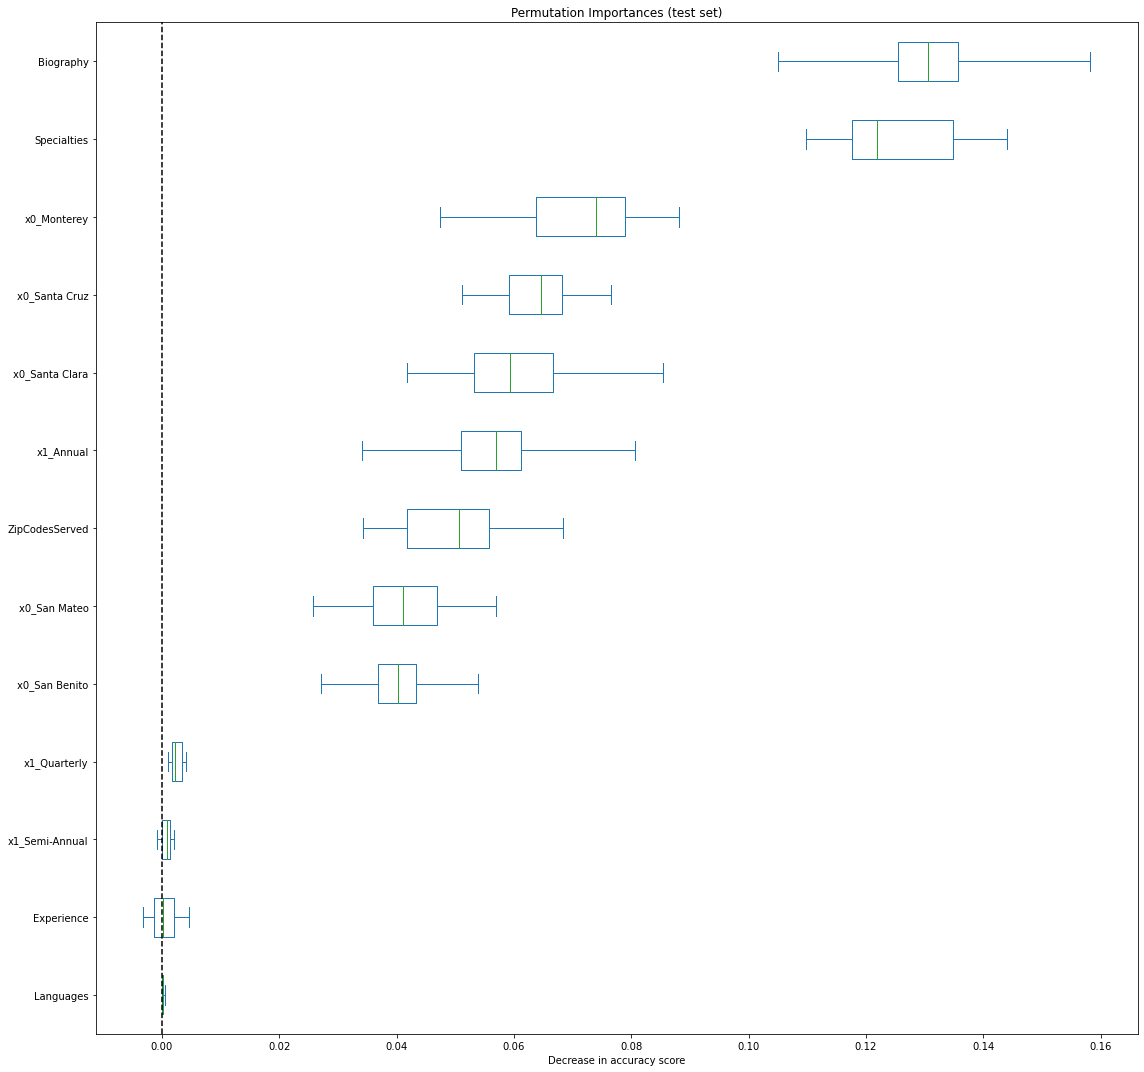

In [154]:
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx2].T,
    columns=columnnames[sorted_importances_idx2], #
)
ax = importances_test.plot.box(vert=False, whis=10, figsize=(16,15))
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [183]:
coefs=lr_model_final.named_steps['classifier'].coef_[0].flatten()

In [156]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(columnnames, coefs)
df = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df["abs_value"] = df["value"].apply(lambda x: abs(x))
df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
df = df.sort_values("abs_value", ascending=False)

Text(0.5, 0, 'Feature Name')

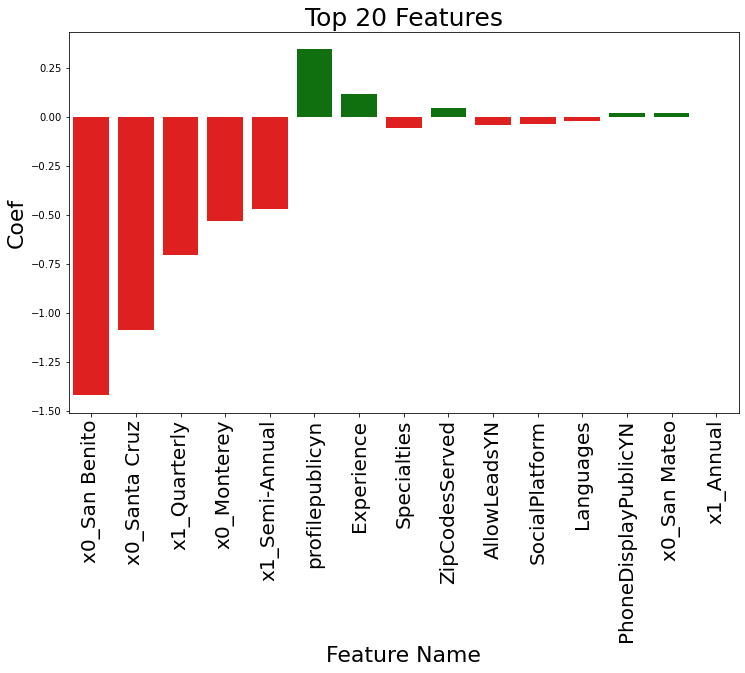

In [157]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df.head(15),
           palette=df.head(15)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

## Findings 

### Interpret Permutation Importance and Coefs

The permutation importance derived from tuned KNN model suggests that Biography and Speciality are the top features that contribute to the success traits of a Top Agent.

The County where an Agent does Business, is the second important feature.

The Top Agent subscriber's also chose annual plan over semi and quarterly plans.

The number of zip codes served and industry experience definitely plays a significant part.

Its also important to advertise the profile's publicly.


## Next Steps

Although we were able to derive some conclusions, the F1 scores were pretty low on the models, which means the model can be further improved by collecting relevant data.

The target field was extremely imbalanced, so trying oversampling or synthetic data generation techniques may further improve the results

The success of Agent is dependent on a lot of external factors like economy, interest rates, pandemic that was not included in the dataset.

Including data related to Broker budget to train the Agents, the different types of tools and services that individual agents use, can substacially contribute to agent success.

Convert the binary fields to actual values and running PCA may help narrow the key features before modeling.